In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install fastai==2.0.11 --quiet
!pip install -Uqq fastbook --quiet
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
bear_types = 'grizzly','black', 'teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results= search_images_ddg(f'{o}  bear')
        download_images(dest, urls=results[:200])
        resize_image(dest,max_size=400, dest=dest)

In [4]:
fns = get_image_files(path)
fns

(#569) [Path('bears/teddy/1f2d23f2-3bf0-4c2f-8a38-3d7166ec77fb.jpg'),Path('bears/teddy/2b1e13e4-6ca7-4cdb-af16-f5847e0d82fd.jpg'),Path('bears/teddy/13e427fa-59f6-423f-b73d-1c50b0b710e4.jpg'),Path('bears/teddy/8566d3a0-d38f-4a37-b264-207e85e9e0c8.jpg'),Path('bears/teddy/7ed4a36d-24ed-4dbf-b182-1679374c360f.jpg'),Path('bears/teddy/83cbc6bd-95aa-4224-84d8-8631210ec33d.jpg'),Path('bears/teddy/6a25c2e2-7e16-4dc1-8b1f-3326c3f10e9a.jpg'),Path('bears/teddy/0190a431-4e93-42a5-9d3d-f1c2f285fdd5.jpg'),Path('bears/teddy/7b6defa6-02f7-44a2-9449-ad7a6d2b4467.jpg'),Path('bears/teddy/cf7d698e-d9e6-4322-a377-4082ecdf64a4.jpg')...]

In [5]:
failed = verify_images(fns)
failed.map(Path.unlink)
len(failed)

29

In [6]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

#bears.show_batch(max_n=16)

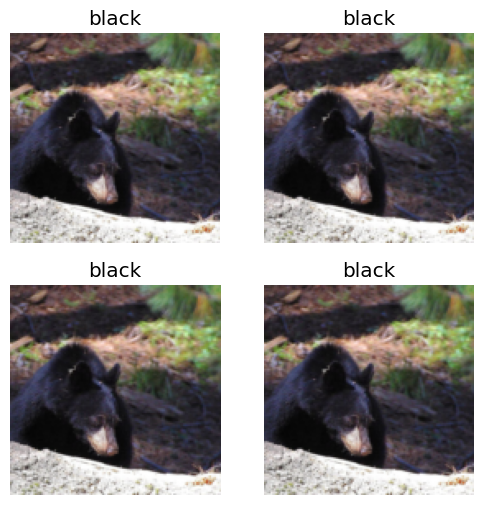

In [7]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4,nrows=2, unique=True)

In [8]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [9]:
learn= vision_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.038332,0.134687,0.046296,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.217482,0.148576,0.046296,01:25
1,0.171541,0.205037,0.055556,01:19
2,0.142076,0.210145,0.046296,00:51
3,0.123507,0.202127,0.046296,00:47


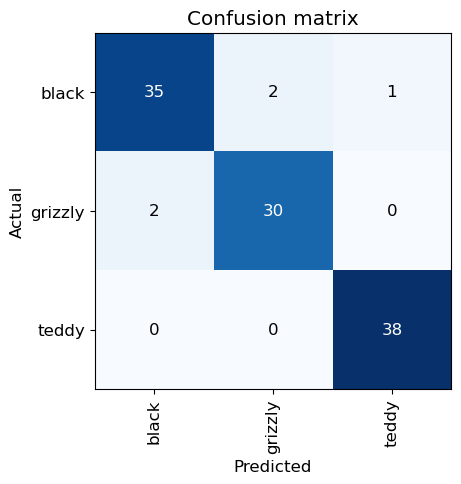

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

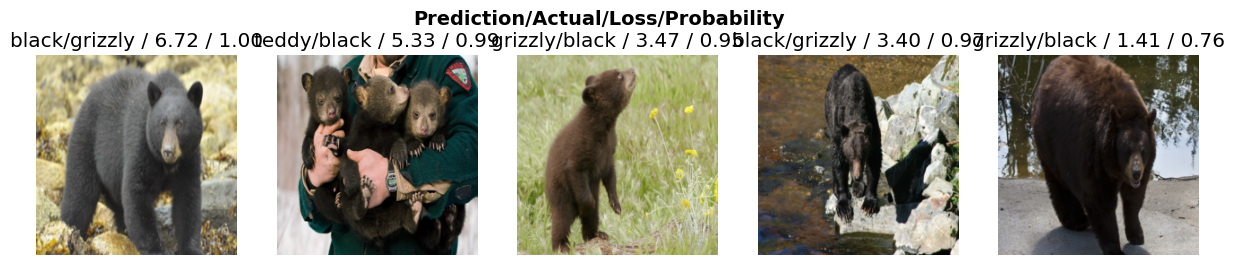

In [11]:
interp.plot_top_losses(5, nrows=1)

In [12]:
from fastai.vision.widgets import *

In [13]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [19]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [21]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [22]:
learn_inf = load_learner(path/'export.pkl')

In [31]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [28]:
import os
os.mkdir('images')

FileExistsError: [Errno 17] File exists: 'images'

In [35]:
btn_upload = SimpleNamespace(data = ['../beartest/bear.jpg'])
os.listdir()

['beartest']

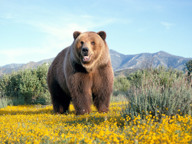

In [36]:

img2 =  PILImage.create("../input/beartest/bear.jpg")
img2.to_thumb(192)

In [43]:
pred,pred_idx,probs = learn_inf.predict(img2)

In [44]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9999')

In [39]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [51]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [52]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run])

In [53]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.5/347.5 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter_client 7.4.9
    Uninstalling jupyter_client-7.4.9:
      Successfully uninstalled jupyter_client-7.4.9
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter_server 2.5.0
    Uninstalling jupyter_server-2.5.0:
      Successfully uninstalled jupyter_server-2.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
Config option `kernel_spec_manager_class` not recognized by `EnableServerExtensionApp`.
Enabling: voil